 <div style="text-align:center;">
  <span style="color:green; font-size:2em; font-weight:bold;">Modélisation</span><br><br>

# <span style="color:green">Introduction</span><br><br> 

### <span style="color:green">Références et équations de base de la relation d'Okun</span><br><br> 

Dans cette partie, nous allons proposer une modélisation permettant de vérifier empiriquement la loi d'Okun, à partir de la base de données "final_data", établie dans la partie "Préparation_données.ipynb".

La loi d'Okun, indique que : "chaque fois que le PIB chute d'un certain pourcentage, par rapport au produit potentiel, le taux de chômage augmente d'environ un point de pourcentage. Ainsi, lorsque le PIB réel diminue, le taux de chômage augmente." (Mankiw, 2003)

Pour cette modélisation, on s'inspire des travaux suivants : 

- [1]. Traoré, D. L., Diakite, S., & Mariko, O. (2021). Croissance et chômage au Mali : Vérification empirique de la loi d'Okun. Revue Malienne de Science et de Technologie, Série C : Sciences Humaines et Sociales, 02(25), Page. ISSN 1987-1031. CNRST, Bamako, Mali.

- [2]. Aassif, Z. L'extraction de la tendance cycle. Haut-Commissariat au Plan, Direction de la comptabilité nationale. 

- [3]. Mills, T. C. (2019). Chapter 12 - Transfer Functions and Autoregressive Distributed Lag Modeling. In Applied Time Series Analysis: A Practical Guide to Modeling and Forecasting (pp. 201-210). Loughborough University, Loughborough, United Kingdom. https://doi.org/10.1016/B978-0-12-813117-6.00012-0

Le travail [1] nous présente deux équations de base de la relation d'Okun, la version en "différences premières" et la "version gap".

- Version en "différences premières" : 
$$\Delta u = c + \beta\Delta \text{pib} + \epsilon$$

- "Version gap" : 
$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$

avec $u$ le taux de chômage, $u^*$ le taux de chômage naturel, $\text{pib}^*$ le PIB potentiel et c, $\beta$ et $\epsilon$  des constantes à déterminer grâce à la modélisation. 

### <span style="color:green">Équation et outils utilisés dans notre modélisation</span><br><br> 

Pour la modélisation, nous allons utiliser la version "gap", qui relie le taux de chômage et le PIB de la manière suivante : 
**$$u - u^* = c + \beta^*(\text{pib} - \text{pib}^*) + \epsilon$$**

Pour extraire la tendance à long terme du taux de chômage et du PIB (c'est-à-dire, le taux de chômage naturel et le PIB potentiel), à partir de la base de données, nous allons utiliser le filtre de **Hodrick-Prescott**. Ce filtre est introduit dans [2], et permet de décomposer une série selon sa tendance à long terme et son cycle (fluctuations autour de la tendance) à plus court terme.

Par ailleurs, pour prendre en compte la dynamique temporelle de nos données, nous allons utiliser le modèle **ARDL** (Auto Regressive Distributed Lag), introduit dans [2].

### <span style="color:green">Les différentes étapes de notre modélisation</span><br><br> 


**1. Clustering des Pays :**
Dans cette première étape, nous regroupons les pays présents dans la base de données selon des critères socio-économiques à l'aide de la technique du **clustering**.

**2. Sélection Aléatoire d'un pays par groupe :**
Au sein de chaque groupe formé lors du clustering, nous choisissons aléatoirement un pays afin d'assurer une représentation équitable.

**3. Modélisation de la Loi d'Okun avec ARDL :**
Nous allons utiliser le modèle ARDL pour modéliser la relation entre le taux de chômage et le PIB réel, et ce pour chacun des pays sélectionnés à l'étape précédente. La modélisation se présente les étapes suivantes :

- Prétraitement des séries temporelles :  nous commençons par différencier les séries des "gap" (écarts entre le taux de chômage naturel et réel, et entre le PIB potentiel et réel) jusqu'à ce qu'elles deviennent stationnaires. La stationnarité est cruciale pour assurer la stabilité des relations à long terme.

- Détermination des paramètres Lags : les paramètres lags nécessaires pour le modèle ARDL sont déterminés en utilisant les fonctions d'autocorrélation (ACF) et d'autocorrélation partielle (PACF). Ces fonctions aident à identifier les retards significatifs à prendre en compte dans la modélisation.

- Régression OLS : Enfin, une régression OLS (Ordinary Least Squares) est appliquée en tenant compte des paramètres lags déterminés. Cela permet de modéliser la relation entre le taux de chômage et l'écart entre le PIB potentiel et le PIB réel, en prenant en compte la dynamique temporelle. L'utilisation de la régression OLS dans le contexte de l'ARDL simplifie la modélisation tout en permettant une interprétation claire des paramètres.

# <span style="color:green"> I- Préparation des Dataframes</span><br><br> 

In [126]:
# Import nécessaire
import declarations as d 

In [127]:
# Importation de la base de données obtenue suite au nettoyage
data = d.pd.read_csv('bases/final_data.csv', encoding='latin-1')

In [128]:
# Visualisation
data.head(2)

,YEAR,COUNTRY,Unemployment_rate,GDP_rate,life_expentancy,pop_growth_rate
0,1994-01,AUS,9.814137,0.501645,77.878049,0.963092
1,1994-01,SVN,14.650000,0.748256,73.404878,-0.115694


### <span style="color:green"> Base de données pour la modélisation</span><br><br> 

Pour la modélisation de la relation entre le PIB et le taux de chômage, nous aurons besoin de ces deux variables pour chaque pays en colonnes et des dates en indice. 

In [129]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_pivot = data.pivot(index=['YEAR'], columns='COUNTRY',
                    values=['Unemployment_rate', 'GDP_rate'])

# Ajuster les noms de colonnes
df_pivot.columns = [f'{col[1]}_{col[0].lower()}' for col in df_pivot.columns]

# Réinitialiser l'index pour avoir les colonnes YEAR et MONTH comme des colonnes régulières
df_pivot.reset_index(inplace=True)

# Renommer les colonnes (supprimer le suffixe _rate)
df_pivot = df_pivot.rename(columns=lambda x: x.replace('_rate', ''))

In [130]:
# Visualisation du nouveau dataframe
df_pivot.head(2)

,YEAR,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
0,1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1,1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


### <span style="color:green"> Base de données pour le clustering </span><br><br> 

Pour le clustering, il nous faut une base de données avec en indice le nom des pays et en colonnes, les différents critères considérés, moyennés sur la période considérée.

In [131]:
# Utilisation de la fonction pivot pour remodeler le dataframe
df_cluster = data.pivot_table(index='COUNTRY', values=['Unemployment_rate', 'GDP_rate','life_expentancy',
       'pop_growth_rate'], aggfunc='mean')

In [132]:
# Visualisation
df_cluster.head(2)

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969


# <span style="color:green">II- Clustering : regroupement des pays selon des critères socio-économiques</span><br><br> 

Dans cette partie, le clustering nous permettra de tirer des groupes homogènes de pays. Quatres (4) critères sont retenus : 

<div style="margin-left: 20px;">
    <span style="font-weight:bold;">1.</span> Le PIB,<br>
    <span style="font-weight:bold;">2.</span> le taux de chômage,<br>
    <span style="font-weight:bold;">3.</span> l'espérance de vie, <br>
    <span style="font-weight:bold;">4.</span> et le taux de croissance de la population.
    </div>

Chaque variable étant moyennée sur la période considérée. 

In [123]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [121]:
# Supprimer les lignes ayant des valeurs manquantes
df_cluster.dropna(inplace=True)

In [122]:
# Visualisation 
df_cluster.head()

,GDP_rate,Unemployment_rate,life_expentancy,pop_growth_rate
COUNTRY,,,,
AUS,0.761392,6.027355,80.916318,1.342107
AUT,0.899732,7.236287,79.720527,0.449969
BEL,0.913237,7.774560,79.483950,0.498965
BGR,0.799515,10.575434,72.878191,-0.792854
CAN,0.922738,7.485185,80.470733,1.032642


c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


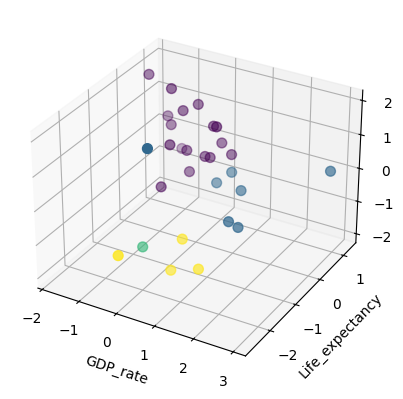

In [124]:
# Standardiser les données (important pour K-means)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cluster)

# Appliquer l'algorithme K-means
num_clusters = 4 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cluster['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualisation en 3D (utilisant les variables GDP_rate, Life_expectance, Pop_growth_rate)
fig = d.plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_scaled[:, 1], df_scaled[:, 2], df_scaled[:, 3], c=df_cluster['Cluster'], cmap='viridis', s=50)
ax.set_xlabel('GDP_rate')
ax.set_ylabel('Life_expectancy')
ax.set_zlabel('Pop_growth_rate')
d.plt.show()

In [125]:
# Afficher les groupes et les pays
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    print(f'Cluster {cluster_num + 1}: {list(countries_in_cluster)}')

Cluster 1: ['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CZE', 'DEU', 'FRA', 'GBR', 'IRL', 'JPN', 'LUX', 'NOR', 'NZL', 'SGP', 'SWE', 'USA']
Cluster 2: ['ESP', 'FIN', 'PHL', 'POL', 'PRT', 'SVK', 'SVN']
Cluster 3: ['ROU']
Cluster 4: ['BGR', 'EST', 'LTU', 'RUS']


# <span style="color:green">III- Extraction de la tendance du taux de chômage et du PIB</span><br><br> 

## <span style="color:green">III-1. Base de données du taux de chômage pour chaque pays </span><br><br> 

In [133]:
# Extraire toutes les colonnes avec le suffixe "_rate" ainsi que la colonne des dates
columns_unemployment = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_unemployment')] 
df_unemployment = df_pivot[columns_unemployment]

# Définir la colonne 'YEAR' comme index 
df_unemployment.set_index('YEAR', inplace = True)

In [134]:
# Visualisation
df_unemployment.head(2)

,AUS_unemployment,AUT_unemployment,BEL_unemployment,BGR_unemployment,CAN_unemployment,CHE_unemployment,CZE_unemployment,DEU_unemployment,ESP_unemployment,EST_unemployment,...,POL_unemployment,PRT_unemployment,ROU_unemployment,RUS_unemployment,SGP_unemployment,SVK_unemployment,SVN_unemployment,SWE_unemployment,URY_unemployment,USA_unemployment
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,9.814137,6.609708,9.641018,14.300000,10.700000,4.704339,4.3,7.261003,22.000000,7.600000,...,16.450000,7.756329,10.9,6.759498,1.750000,14.620000,14.650000,10.839335,12.100000,6.2
1994-02,10.269157,6.582263,9.728535,15.393333,10.866667,4.839299,4.2,7.521107,22.233333,7.466667,...,16.533333,7.916827,10.9,6.574419,1.666667,14.426667,14.966667,10.866990,12.083333,6.5


## <span style="color:green">III-2. Base de données du PIB réel pour chaque pays</span><br><br> 

In [135]:
# Extraire toutes les colonnes avec le suffixe "_gdp" ainsi que la colonne des dates
columns_gdp = ['YEAR'] + [col for col in df_pivot.columns if col.endswith('_gdp')] 
df_gdp = df_pivot[columns_gdp]

# Définir la colonne 'YEAR' comme index 
df_gdp.set_index('YEAR', inplace = True)

In [136]:
# Visualisation
df_gdp.head(2)

,AUS_gdp,AUT_gdp,BEL_gdp,BGR_gdp,CAN_gdp,CHE_gdp,CZE_gdp,DEU_gdp,ESP_gdp,EST_gdp,...,POL_gdp,PRT_gdp,ROU_gdp,RUS_gdp,SGP_gdp,SVK_gdp,SVN_gdp,SWE_gdp,URY_gdp,USA_gdp
YEAR,,,,,,,,,,,,,,,,,,,,,
1994-01,0.501645,0.779464,0.796550,0.559233,0.680429,0.907331,0.814153,0.794548,0.774291,0.525902,...,0.744291,0.753611,1.405948,0.131693,0.806523,0.781847,0.748256,0.585296,NaN,0.650468
1994-02,0.502208,0.783616,0.798246,0.559740,0.680180,0.909250,0.818056,0.796374,0.778426,0.534253,...,0.745930,0.757949,1.443999,0.134277,0.812181,0.773778,0.754609,0.587775,NaN,0.653595


## <span style="color:green">III-3. Extraction de la tendance du PIB et du taux de chômage d'un pays </span><br><br> 


Dans cette partie, on définit une classe qui permet de tracer la tendance à long terme et les cycles à court terme des deux variables considérées. 

La méthode **df_gap()** de cette classe permet d'obtenir une série avec les valeurs de la différence entre la valeur réelle et la tendance des deux variables considérées, pour un pays considéré. 

In [137]:
class CountryData:
    def __init__(self, country_code, unemployment_data, gdp_data):
        """
        Initialize a CountryData instance.

        Parameters:
        - country_code (str): The country code.
        - unemployment_data (pd.Series): Time series data for unemployment rate.
        - gdp_data (pd.Series): Time series data for GDP rate.
        """
        
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']

    def plot_trend_cycle(self):
        """
        Plot the trend and cycle components for unemployment rate and GDP rate after applying the Hodrick-Prescott filter to the time series.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)

        # Plot the trend and cycle of unemployment rate
        d.plt.plot(x, label='Original series')
        d.plt.plot(trend_x, label='Trend')
        d.plt.plot(cycle_x, label='Cycle')
        d.plt.legend()
        d.plt.show()

        # Extraction de la tendance à long terme du PIB
        y = self.gdp_rate

        # Appliquer le filtre de Hodrick-Prescott 
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)

        # Plot the trend and cycle of the trend
        d.plt.plot(y, label='Originale series')
        d.plt.plot(trend_y, label='Trend')
        d.plt.plot(cycle_y, label='Cycle')
        d.plt.legend()
        d.plt.show()
        
    def df_gap(self):
        
        """
        Calculate the gap series for unemployment rate and GDP rate.

        Returns:
        - df_gap (pd.DataFrame): DataFrame containing the gap values.
        """
        # Extraction of the long-term trend of unemployment rate
        x = self.unemployment_rate

        # Applying the Hodrick-Prescott filter
        trend_x, cycle_x = d.smf.hpfilter(x, lamb=1600)
    
        # Extraction of the long-term trend of GDP
        y = self.gdp_rate

        # Applying the Hodrick-Prescott filter
        trend_y, cycle_y = d.smf.hpfilter(y, lamb=1600)
    
        # Calculate the new series by removing the trend
        gap_unemployment = x - trend_x
        gap_gdp = y - trend_y

        # Create a DataFrame with the new series
        df_x = d.pd.DataFrame({'YEAR': x.index, 'gap_unemployment': gap_unemployment.values})
        df_y = d.pd.DataFrame({'YEAR': y.index, 'gap_gdp': gap_gdp.values})

        # Merge the DataFrames on the 'YEAR' column
        df_gap = d.pd.merge(df_x, df_y, on='YEAR', how='inner')

        return df_gap


# <span style="color:green">IV- Vérification de la loi pour un pays tiré aléatoirement dans chaque groupe</span><br><br>

## <span style="color:green">IV-1. Modèle ARDL : modélisation de la relation PIB/taux de chômage </span><br><br>

In [138]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [148]:
class PreProcessing:
    def __init__(self, country_code, unemployment_data, gdp_data):
        self.country_code = country_code
        self.unemployment_rate = unemployment_data[f'{country_code}_unemployment']
        self.gdp_rate = gdp_data[f'{country_code}_gdp']
        self.country = CountryData(self.country_code, unemployment_data, gdp_data)
        self.unemployment_series = self.country.df_gap()['gap_unemployment']
        self.gdp_series = self.country.df_gap()['gap_gdp']

    def differentiation(self, series):
        # Différenciation des séries temporelles
        return series.diff().dropna()

    def stationarity_test(self, series, name):
        result = d.adfuller(series, autolag='AIC')
        #print(f'Test ADF pour la série {name}:')
        #print(f'ADF Statistic: {result[0]}')
        #print(f'p-value: {result[1]}')
        #print(f'Nombre de lags utilisés: {result[2]}')
        #print(f'Nombre d\'observations utilisées: {result[3]}')
        #print(f'Valeurs critiques:')
        #for key, value in result[4].items():
            #print(f'   {key}: {value}')

        p_value = result[1]
        i = 0
        diff_series = [series]
        while p_value > 0.05:
            diff_series.append(self.differentiation(diff_series[i]))
            result = d.adfuller(diff_series[i + 1], autolag='AIC')
            p_value = result[1]
            i += 1

        return diff_series[i]

    def ACF_PACF_plot(self):
        """Cette fonction permet d'afficher les graphiques de l'ACF et du PACF des séries stationnaires (obtenues après différenciation ou non).
        A partir de ces graphiques, nous allons pouvoir déterminer le nombre de retards significatifs à considérer pour chacune des séries."""
        
        diff_unemployment_series = self.stationarity_test(self.unemployment_series, 'Unemployment_rate')
        diff_gdp_series = self.stationarity_test(self.gdp_series, 'Real_GDP')

        df_diff = d.pd.DataFrame({
            'Unemployment_rate': diff_unemployment_series,
            'Real_GDP': diff_gdp_series
        })

        # Créer une figure et des axes pour les graphiques
        fig, axes = d.plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

        # ACF - Diff_Unemployment_rate
        plot_acf(df_diff['Unemployment_rate'], ax=axes[0, 0], lags=40, title='ACF - Unemployment_rate')

        # PACF - Diff_Unemployment_rate
        plot_pacf(df_diff['Unemployment_rate'], ax=axes[0, 1], lags=40, title='PACF - Unemployment_rate')

        # ACF - Diff_Real_GDP
        plot_acf(df_diff['Real_GDP'], ax=axes[1, 0], lags=40, title='ACF - Real_GDP')

        # PACF - Diff_Real_GDP
        plot_pacf(df_diff['Real_GDP'], ax=axes[1, 1], lags=40, title='PACF - Real_GDP')

        # Ajuster l'espacement entre les graphiques
        d.plt.tight_layout()

        # Afficher la figure
        d.plt.show()

In [140]:
class ARDLAnalysis:
    def __init__(self, country_code, unemployment_data, gdp_data, lags_ur, lags_gdp):
        self.country_code = country_code
        self.lags_ur = lags_ur
        self.lags_gdp = lags_gdp
        self.unemployment_series, self.gdp_series = self.preprocess_data(unemployment_data, gdp_data)

    def preprocess_data(self, unemployment_data, gdp_data):
        preprocessing = PreProcessing(self.country_code, unemployment_data, gdp_data)
        return preprocessing.stationarity_test(preprocessing.unemployment_series, 'Unemployment_rate'), \
               preprocessing.stationarity_test(preprocessing.gdp_series, 'Real_GDP')

    def create_explanatory_matrix(self):
        df_diff = d.pd.DataFrame({
            'Unemployment_rate': self.unemployment_series,
            'Real_GDP': self.gdp_series
        })
        self.df_diff = df_diff 
        x = sm.add_constant(df_diff[['Unemployment_rate', 'Real_GDP']])
        for lag in range(1, max(self.lags_ur, self.lags_gdp) + 1):
            x[f'Unemployment_rate_{lag}'] = df_diff['Unemployment_rate'].shift(lag)
            x[f'Real_GDP_{lag}'] = df_diff['Real_GDP'].shift(lag)
        return x.dropna()

    def define_dependent_variable(self):
        y = self.df_diff['Real_GDP'].shift(-1).dropna()
        return y[y.index.isin(self.x.index)]

    def fit_ardl_model(self):
        self.x = self.create_explanatory_matrix()
        self.y = self.define_dependent_variable()

        # Vérifier que les deux dataframes ont bien les mêmes données
        Y = self.y[self.y.index.isin(self.x.index)]
        X = self.x[self.x.index.isin(Y.index)]

        # Ajuster le modèle ARDL
        model = sm.OLS(Y, X)
        results = model.fit()

        # Afficher les résultats
        return results.summary()

## <span style="color:green">IV-2.  Application du modèle à un pays sélectionné aléatoirement pour chaque cluster </span><br><br>

### <span style="color:green">IV.2.1. Tirage aléatoire d'un pays dans chaque cluster </span><br><br>

In [ ]:
# Afficher le pays sélectionné de manière aléatoire dans chaque cluster
list_random_countries = []
for cluster_num in range(num_clusters):
    countries_in_cluster = df_cluster[df_cluster['Cluster'] == cluster_num].index
    random_country = d.np.random.choice(countries_in_cluster)
    list_random_countries.append(random_country)
    print(f'Cluster {cluster_num + 1}: {random_country}')

In [74]:
print(f'Le code des pays sélectionnés dans chaque cluster sont les suivants', list_random_countries)

Le code des pays sélectionnés dans chaque cluster sont les suivants ['BEL', 'SVN', 'ROU', 'EST']


### <span style="color:green">IV.2.2. Pays du cluster 1  </span><br><br>

La stationnarité est une condition importante pour l'application de modèles ARDL. Cette première étape va donc permettre de vérifier si les séries Unemployment_rate et Real_GDP sont stationnaires et de les différencier jusqu'à l'obtention de séries stationnaires, le cas contraire.

Unemployment_rate contient les valeurs de la différence entre le taux de chômage réel et sa tendance.
Real_GDP contient les valeurs de la différence entre le PIB réel et sa tendance.

Par ailleurs, après obtention de séries stationnaires, nous souhaitons déterminer le nombre approprié de retards significatifs (lags) à considérer dans notre modèle pour chacune des séries. Pour cela, nous pouvons nous servir des graphiques de la fonction d'autocorrélation (ACF) et de la fonction d'autocorrélation partielle (PACF). Ces graphiques aident à visualiser les corrélations entre les observations à différents retards. Nous devons rechercher des retards significatifs où les corrélations sont en dehors de l'intervalle de confiance.

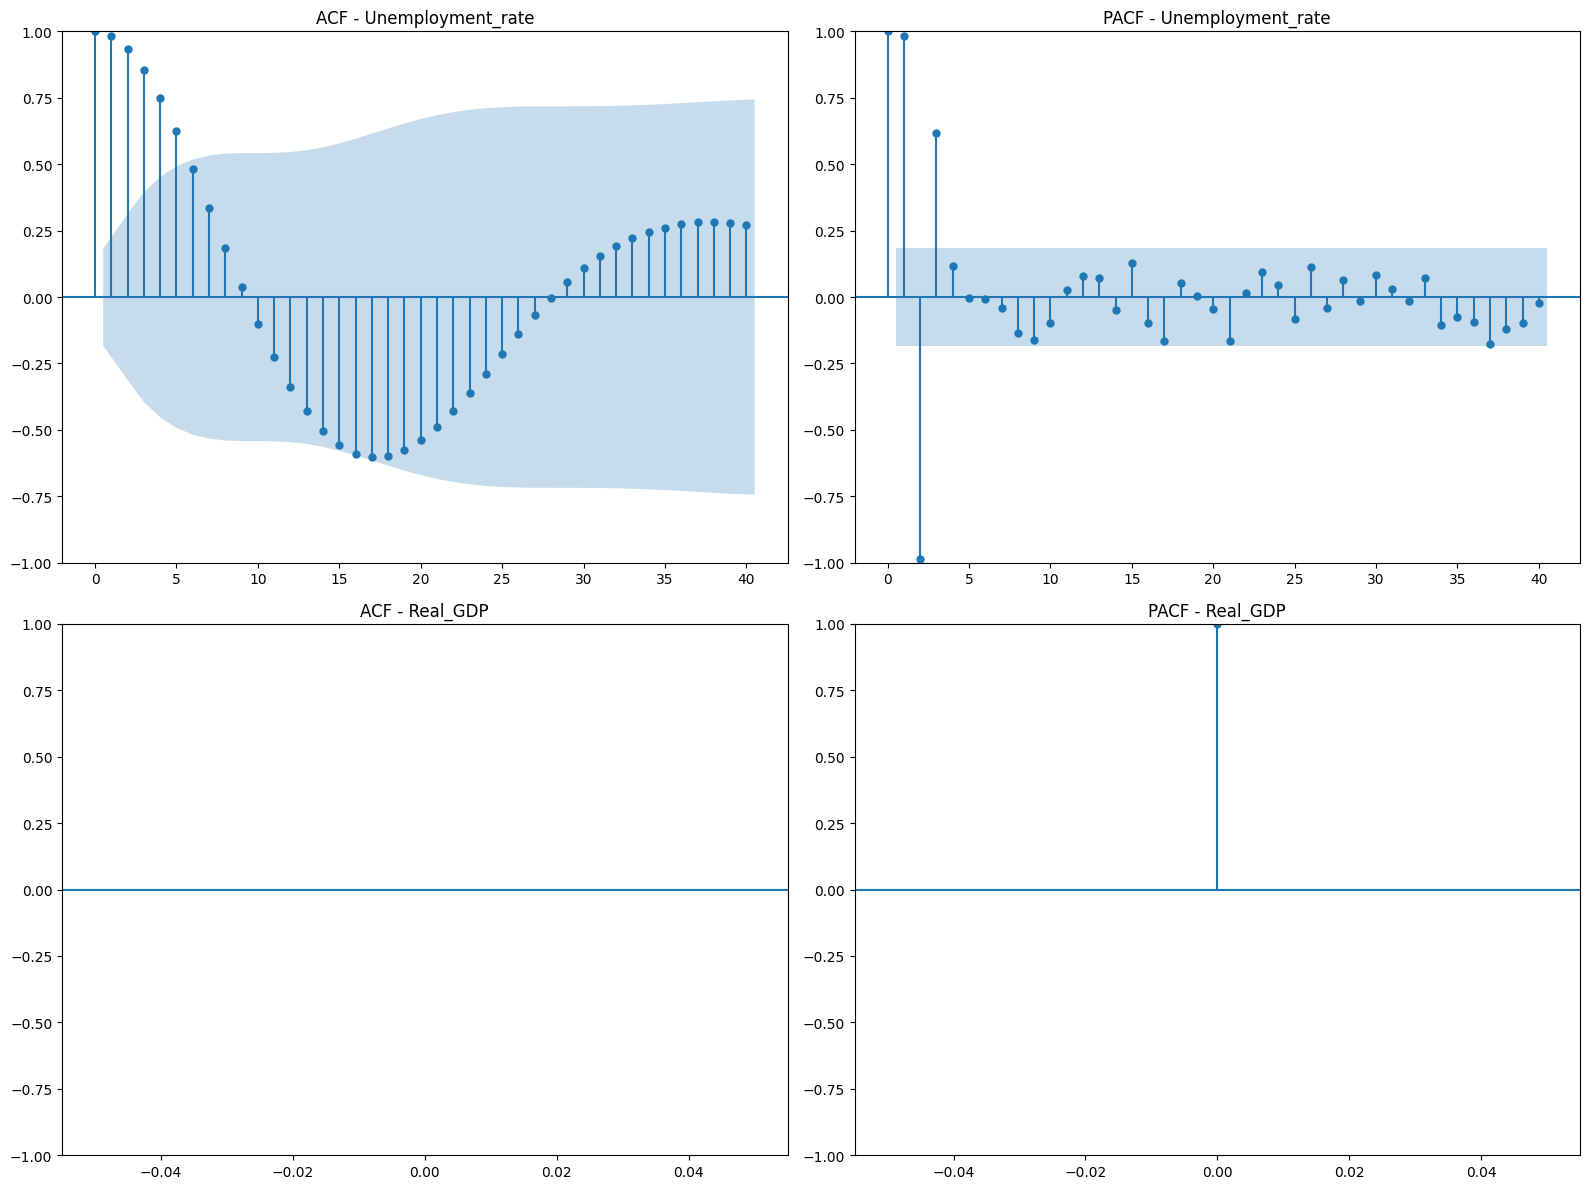

In [75]:
country_code1 = list_random_countries[0]
country1 = PreProcessing(country_code1, df_unemployment, df_gdp)
country1.ACF_PACF_plot()

En observant les graphiques, le lecteur doit définir les lags appropriés dans la cellule code qui suit. Pour cela, il faut compter le nombre de pics en dehors de l'intervalle de confiance des graphes ACF et PACF et retenir le nombre maximal entre les deux, et ce, pour chacune des variables "Unemployment_rate" et "Real_GDP".

N.B. Si l'ACF et le PACF sont nuls sauf pour un nombre fini de points, il faut prendre un nombre de lags nul.

In [76]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_1 = 6  # Lags pour Unemployment_rate
lags_gdp_1 = 0  # Lags pour Real_GDP

La cellule code qui suit, nous permet d'obtenir les résultats de la modélisation. 

N.B. Le modèle utilisé est une spécification simple d'un modèle ARDL (AutoRegressive Distributed Lag), qui utilise la régression OLS. Cependant, la dynamique temporelle est partiellement prise en compte dans la mesure où le modèle inclut un lag du taux de chômage (Unemployment_rate) pour capturer l'effet retardé sur la variable dépendante (Real_GDP).

In [77]:
country1_model = ARDLAnalysis(country_code1, df_unemployment, df_gdp, lags_ur_1, lags_gdp_1)
country1_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       0.719
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     16.62
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           2.34e-19
Time:                        19:14:22   Log-Likelihood:                 1239.1
No. Observations:                 106   AIC:                            -2448.
Df Residuals:                      91   BIC:                            -2408.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -2.028e-08   2.23e-07     -0.091      0.928   -4.62e-07    4.22e-07
Unemployment_rate      -0.0009      0.001     -0.710      0.479      -0.003       0.002
Real_GDP                0.8846      0.106      8.357      0.000       0.674       1.095
Unemployment_rate_1     0.0023      0.003      0.695      0.489      -0.004       0.009
Real_GDP_1             -0.0967      0.139     -0.698      0.487      -0.372       0.178
Unemployment_rate_2    -0.0024      0.004     -0.574      0.567      -0.011       0.006
Real_GDP_2              0.1436      0.140      1.025      0.308      -0.135       0.422
Unemployment_rate_3     0.0032      0.004      0.783      0.436      -0.005       0.011
Real_GDP_3             -0.0657      0.141     -0.466      0.642      -0.346       0.214
Unemployment_rate_4    -0.0038      0.004     -0.925      0.357      -0.012       0.004
Real_GDP_4             -0.0174      0.114     -0.153      0.879      -0.244       0.209
Unemployment_rate_5     0.0010      0.003      0.302      0.764      -0.006       0.008
Real_GDP_5             -0.1076      0.068     -1.586      0.116      -0.242       0.027
Unemployment_rate_6     0.0005      0.001      0.424      0.673      -0.002       0.003
Real_GDP_6             -0.0107      0.055     -0.194      0.846      -0.120       0.099
==============================================================================
Omnibus:                       10.991   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               29.446
Skew:                           0.092   Prob(JB):                     4.04e-07
Kurtosis:                       5.576   Cond. No.                     9.56e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Conclusion : 

Nous réitérons la même méthode pour les autres pays sélectionnés.

### <span style="color:green">IV.2.3. Pays du cluster 2  </span><br><br>

In [155]:
country_code2 = list_random_countries[1]
country2 = PreProcessing(country_code2, df_unemployment, df_gdp)
country2.ACF_PACF_plot()

TypeError: PreProcessing.stationarity_test() takes 2 positional arguments but 3 were given

In [79]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_2 = 6  # Lags pour Unemployment_rate
lags_gdp_2 = 5  # Lags pour Real_GDP

In [142]:
# Exemple avec AutoReg
from statsmodels.tsa.api import AutoReg

In [154]:
import pandas as pd
from statsmodels.tsa.api import AutoReg
from statsmodels.tools import add_constant


test = ARDLAnalysis(country_code2, df_unemployment, df_gdp, lags_ur_2, lags_gdp_2)
data_diff = d.pd.DataFrame({
            'Unemployment_rate': test.unemployment_series,
            'Real_GDP': test.gdp_series
        })

# Ajoute une constante à la matrice explicative
data_diff_with_const = add_constant(data_diff)

# Spécifie le modèle AutoReg avec les retards
lags_ur = 1  # ajuste le nombre de lags pour le taux de chômage
lags_gdp = 1  # ajuste le nombre de lags pour le PIB réel
model = AutoReg(data_diff['Diff_Real_GDP'], lags=[lags_ur, lags_gdp], trend='c', exog=data_diff_with_const)
results = model.fit()

# Affiche les résultats de la régression
print(results.summary())


TypeError: PreProcessing.stationarity_test() takes 2 positional arguments but 3 were given

In [150]:
# Utiliser les séries différenciées
diff_unemployment_series = country2.stationarity_test(country2.unemployment_series, 'Unemployment_rate')
diff_gdp_series = country2.stationarity_test(country2.gdp_series, 'Real_GDP')

# Concaténer les séries différenciées avec les retards
data = d.pd.concat([diff_unemployment_series, diff_gdp_series], axis=1)
data.columns = ['Diff_Unemployment_rate', 'Diff_Real_GDP']

# Spécifier le modèle AutoReg avec les retards
model = AutoReg(data, lags={'Diff_Unemployment_rate': lags_ur_2, 'Diff_Real_GDP': lags_gdp_2}, trend='c')
results = model.fit()

# Afficher les résultats
print(results.summary())


c:\Users\Amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


TypeError: lags must be integer_like (int or np.integer, but not bool or timedelta64)

In [ ]:
country2_model = ARDLAnalysis(country_code1, df_unemployment, df_gdp, lags_ur_2, lags_gdp_2)
country2_model.fit_ardl_model()

Conclusion : 

### <span style="color:green">IV.2.4. Pays du cluster 3  </span><br><br>

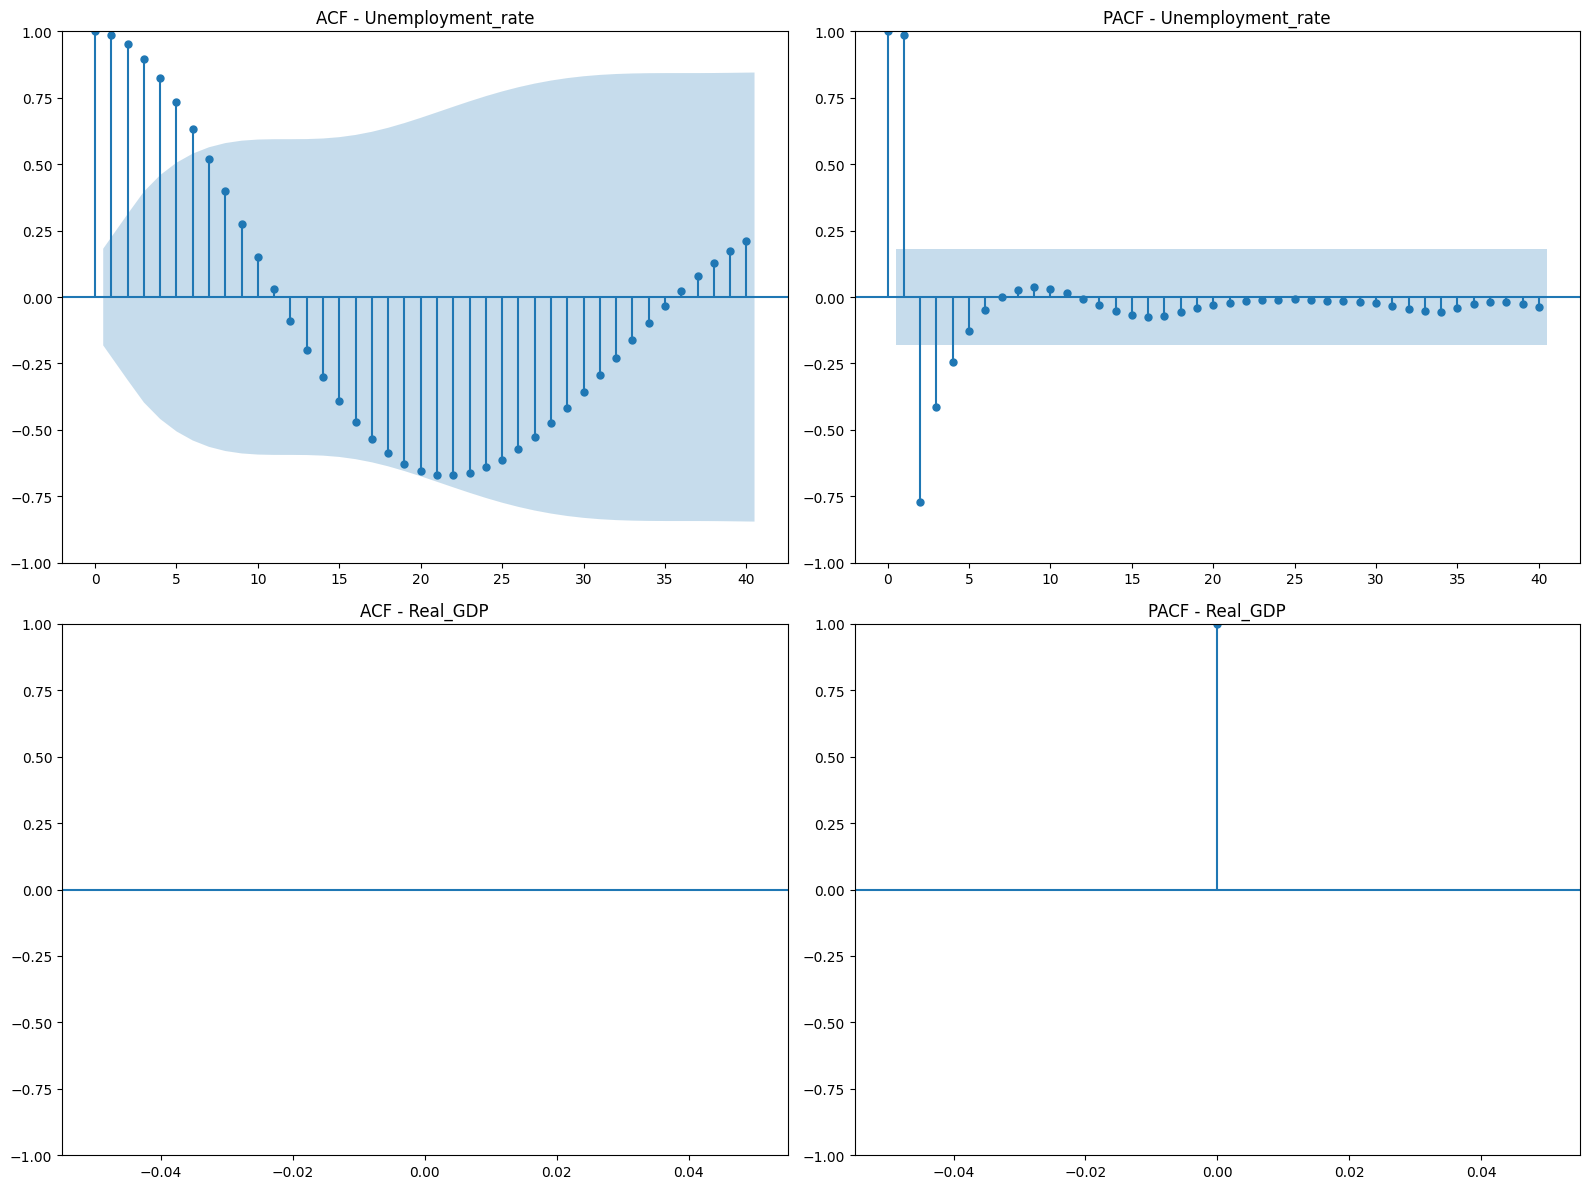

In [81]:
country_code3 = list_random_countries[2]
country3 = PreProcessing(country_code3, df_unemployment, df_gdp)
country3.ACF_PACF_plot()

In [82]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_3 = 7  # Lags pour Unemployment_rate
lags_gdp_3 = 0  # Lags pour Real_GDP

In [83]:
country3_model = ARDLAnalysis(country_code3, df_unemployment, df_gdp, lags_ur_3, lags_gdp_3)
country3_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     182.6
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           8.92e-61
Time:                        19:14:26   Log-Likelihood:                 905.66
No. Observations:                 106   AIC:                            -1777.
Df Residuals:                      89   BIC:                            -1732.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                2.192e-05   1.29e-05      1.704      0.092   -3.65e-06    4.75e-05
Unemployment_rate       0.0284      0.025      1.154      0.252      -0.021       0.077
Real_GDP                1.4999      0.107     13.990      0.000       1.287       1.713
Unemployment_rate_1    -0.1248      0.092     -1.356      0.179      -0.308       0.058
Real_GDP_1             -0.6646      0.188     -3.532      0.001      -1.038      -0.291
Unemployment_rate_2     0.2529      0.151      1.674      0.098      -0.047       0.553
Real_GDP_2              0.1141      0.200      0.571      0.570      -0.283       0.511
Unemployment_rate_3    -0.2883      0.161     -1.790      0.077      -0.608       0.032
Real_GDP_3              0.2433      0.196      1.239      0.219      -0.147       0.633
Unemployment_rate_4     0.1735      0.158      1.100      0.274      -0.140       0.487
Real_GDP_4             -0.3128      0.190     -1.647      0.103      -0.690       0.065
Unemployment_rate_5    -0.0245      0.143     -0.171      0.865      -0.310       0.260
Real_GDP_5              0.0918      0.141      0.652      0.516      -0.188       0.372
Unemployment_rate_6    -0.0314      0.085     -0.367      0.714      -0.201       0.138
Real_GDP_6             -0.1014      0.118     -0.863      0.391      -0.335       0.132
Unemployment_rate_7     0.0146      0.022      0.655      0.514      -0.030       0.059
Real_GDP_7              0.0447      0.067      0.665      0.508      -0.089       0.178
==============================================================================
Omnibus:                       22.730   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.876
Skew:                          -0.839   Prob(JB):                     1.09e-10
Kurtosis:                       5.751   Cond. No.                     6.46e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### <span style="color:green">IV.2.5. Pays du cluster 4  </span><br><br>

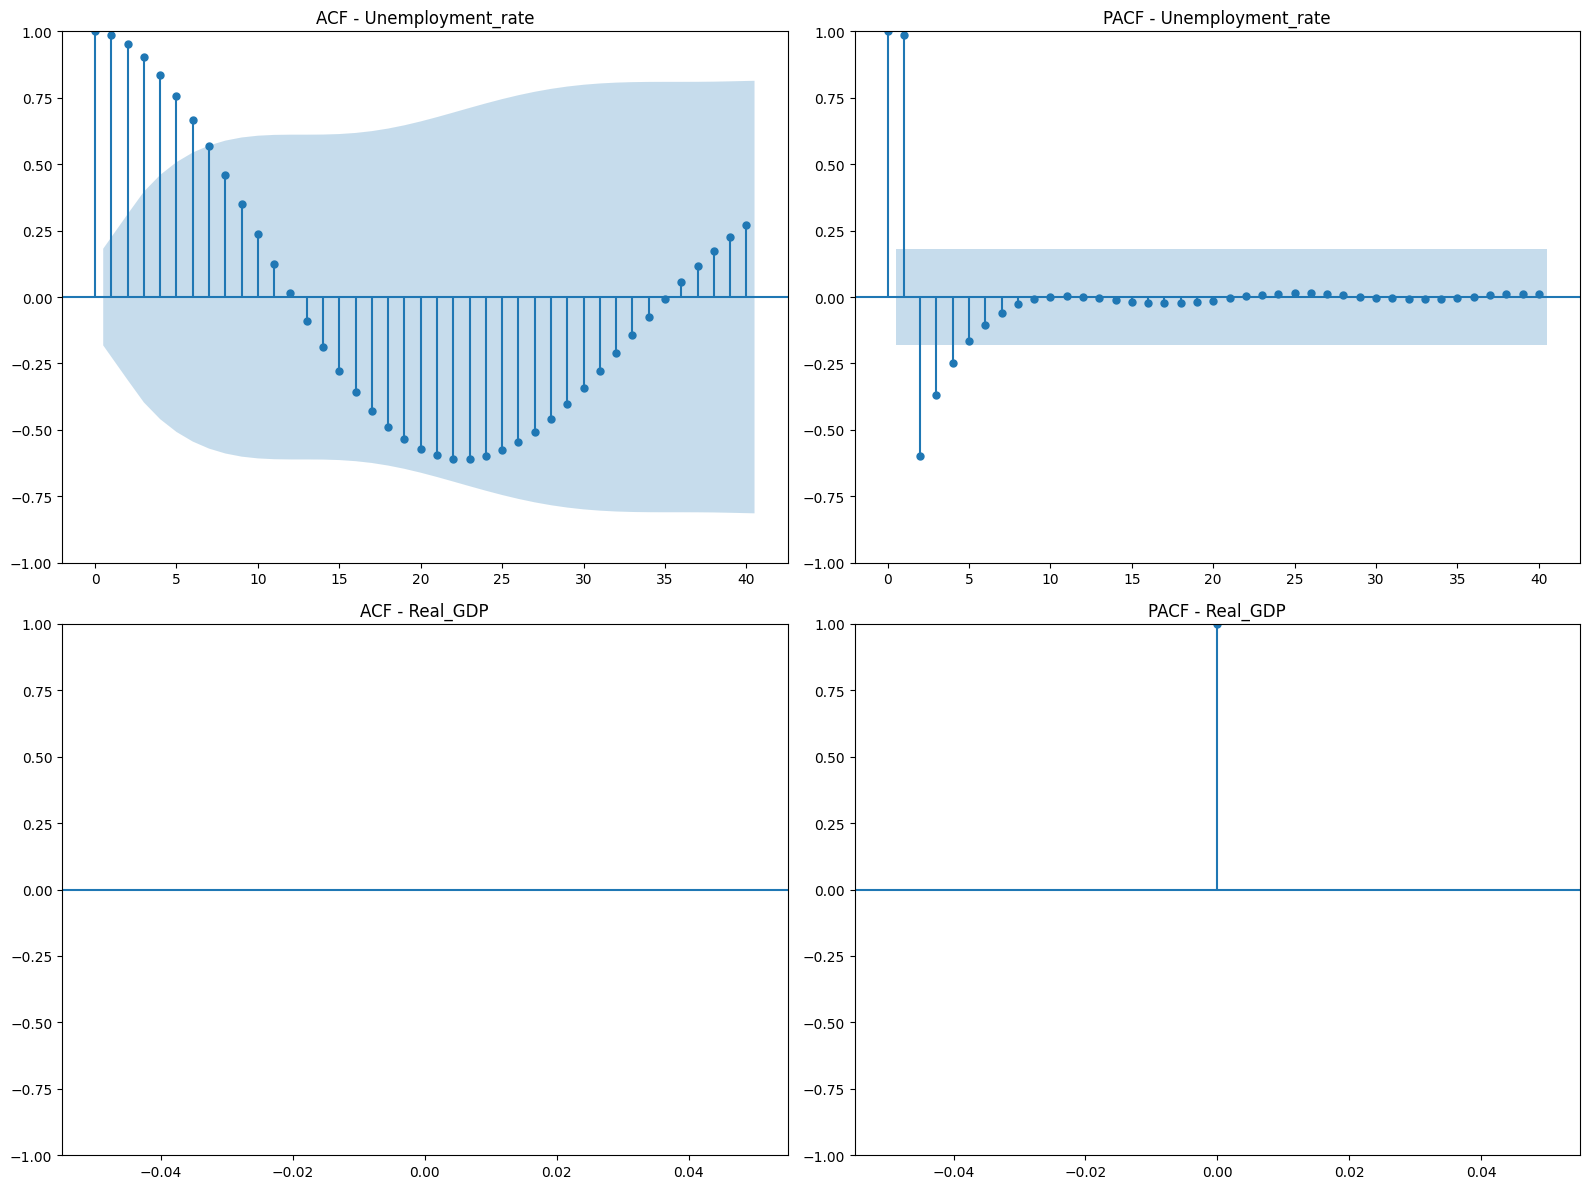

In [84]:
country_code4 = list_random_countries[3]
country4 = PreProcessing(country_code4, df_unemployment, df_gdp)
country4.ACF_PACF_plot()

In [85]:
# Définir les lags appropriés (le nombre de premiers pics en dehors de l'intervalle de confiance, nombre maximal entre graphe ACF et graphe PACF)
lags_ur_4 = 7  # Lags pour Unemployment_rate
lags_gdp_4 = 0  # Lags pour Real_GDP

In [86]:
country4_model = ARDLAnalysis(country_code4, df_unemployment, df_gdp, lags_ur_4, lags_gdp_4)
country4_model.fit_ardl_model()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Real_GDP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     490.2
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           1.93e-79
Time:                        19:14:28   Log-Likelihood:                 1120.3
No. Observations:                 106   AIC:                            -2207.
Df Residuals:                      89   BIC:                            -2161.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1.461e-06   8.23e-07     -1.775      0.079    -3.1e-06    1.74e-07
Unemployment_rate      -0.0030      0.002     -1.651      0.102      -0.007       0.001
Real_GDP                1.5126      0.098     15.442      0.000       1.318       1.707
Unemployment_rate_1     0.0094      0.007      1.364      0.176      -0.004       0.023
Real_GDP_1             -0.1514      0.183     -0.827      0.411      -0.516       0.213
Unemployment_rate_2    -0.0103      0.011     -0.899      0.371      -0.033       0.012
Real_GDP_2             -0.5215      0.187     -2.784      0.007      -0.894      -0.149
Unemployment_rate_3     0.0041      0.013      0.325      0.746      -0.021       0.029
Real_GDP_3              0.2213      0.197      1.124      0.264      -0.170       0.612
Unemployment_rate_4 -6.561e-05      0.012     -0.005      0.996      -0.024       0.024
Real_GDP_4             -0.5123      0.196     -2.618      0.010      -0.901      -0.124
Unemployment_rate_5    -0.0009      0.011     -0.081      0.935      -0.022       0.020
Real_GDP_5              0.2892      0.117      2.467      0.016       0.056       0.522
Unemployment_rate_6     0.0016      0.006      0.256      0.799      -0.011       0.014
Real_GDP_6              0.1232      0.084      1.465      0.147      -0.044       0.290
Unemployment_rate_7    -0.0009      0.002     -0.547      0.585      -0.004       0.002
Real_GDP_7             -0.0842      0.047     -1.792      0.077      -0.178       0.009
==============================================================================
Omnibus:                        6.040   Durbin-Watson:                   2.189
Prob(Omnibus):                  0.049   Jarque-Bera (JB):                9.699
Skew:                           0.058   Prob(JB):                      0.00783
Kurtosis:                       4.477   Cond. No.                     3.97e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Conclusion : 

# <span style="color:green">Conclusion </span><br><br>